# Image Colorization  And Image Restoration

## Image Colorization using Autoencoders

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from keras.applications.vgg16 import VGG16

In [40]:
pre_trained_model = VGG16(include_top = False, weights='imagenet')

In [41]:
for layer in model.layers:
    layer.trainable = False
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [42]:
from keras.preprocessing.image import ImageDataGenerator

In [43]:
train_data_gen = ImageDataGenerator(rescale=1./255)
train_dataset = train_data_gen.flow_from_directory('dataset/image_data/',target_size=(224,224),batch_size=64,class_mode=None)

Found 1996 images belonging to 1 classes.


In [44]:
Lightness_channel = []
color_channel = []

for image in train_dataset[0]:
    try:
        image_lab = cv2.cvtColor(image,cv2.COLOR_RGB2Lab)
        Lightness_channel.append(image_lab[:,:,0])
        color_channel.append(image_lab[:,:,1:]/128)
    except:
        print('Error')
        
Lightness_channel = np.array(Lightness_channel)
Lightness_channel = Lightness_channel.reshape(Lightness_channel.shape+(1,))
color_channel = np.array(color_channel)
print(Lightness_channel.shape)
print(color_channel.shape)

(64, 224, 224, 1)
(64, 224, 224, 2)


In [46]:
vggfeatures = []
for i,sample in enumerate(Lightness_channel):
    sample = cv2.cvtColor(sample,cv2.COLOR_GRAY2RGB)
    sample = sample.reshape((1,224,224,3))
    prediction = pre_trained_model.predict(sample)
    prediction = prediction.reshape((7,7,512))
    vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)    

(64, 7, 7, 512)


In [47]:
from keras.models import Sequential
from keras.layers import Conv2D,UpSampling2D,Activation

In [48]:
model = Sequential()

model.add(Conv2D(512,3,activation='relu',padding='same',input_shape=(7,7,512)))
model.add(Conv2D(512,3,activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(2,3,activation='tanh',padding='same'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
up_sampling2d_27 (UpSampling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 128)       589952    
_________________________________________________________________
up_sampling2d_28 (UpSampling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 28, 28, 64)        73792     
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 56, 56, 64)       

In [28]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

In [37]:
optimizer = Adam(lr=0.0005)
checkpoint = ModelCheckpoint('image_colorization.h5',monitor='accuracy',mode='max',verbose=1,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=2,min_lr=0.00001,model='auto')
callbacks = [checkpoint,reduce_lr]
model.compile(optimizer=optimizer,loss='mse',metrics=['accuracy'])

In [38]:
model.fit(vggfeatures,color_channel,epochs=20,batch_size=100,callbacks=callbacks)

Epoch 1/20
64/64 [==============================] - 11s 175ms/step - loss: 0.0193 - accuracy: 0.5680

Epoch 00001: saving model to image_colorization.h5
Epoch 2/20
64/64 [==============================] - 11s 171ms/step - loss: 0.0193 - accuracy: 0.5684

Epoch 00002: saving model to image_colorization.h5
Epoch 3/20
64/64 [==============================] - 10s 160ms/step - loss: 0.0193 - accuracy: 0.5669

Epoch 00003: saving model to image_colorization.h5
Epoch 4/20
64/64 [==============================] - 11s 179ms/step - loss: 0.0192 - accuracy: 0.5677

Epoch 00004: saving model to image_colorization.h5
Epoch 5/20
64/64 [==============================] - 10s 159ms/step - loss: 0.0191 - accuracy: 0.5679

Epoch 00005: saving model to image_colorization.h5
Epoch 6/20
64/64 [==============================] - 10s 160ms/step - loss: 0.0191 - accuracy: 0.5681

Epoch 00006: saving model to image_colorization.h5
Epoch 7/20
64/64 [==============================] - 10s 154ms/step - loss: 0.0191 

In [61]:
from skimage.transform import resize
from skimage.io import imsave
from keras.preprocessing.image import img_to_array,load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb

In [65]:
def display(images):
    test = img_to_array(images)
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = cv2.cvtColor(test,cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    L = cv2.cvtColor(l,cv2.COLOR_GRAY2RGB)
    L = L.reshape((1,224,224,3))
    vggpred = pre_trained_model.predict(L)
    ab = model.predict(vggpred)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    image = lab2rgb(cur)
    return image

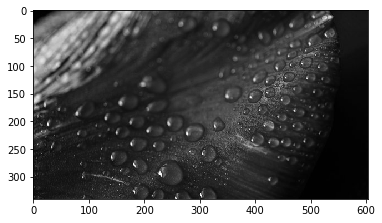

In [75]:
petal_image = cv2.imread('dataset/testimages/[pixabay.com][523]petal-5044428340.jpg')
petal_image = cv2.cvtColor(petal_image,cv2.COLOR_BGR2RGB)
plt.imshow(petal_image)

In [69]:
import warnings
warnings.filterwarnings('ignore')

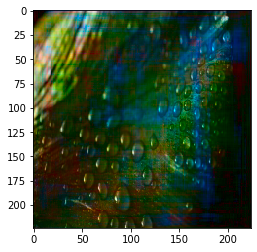

In [77]:
prediction = display(petal_image)
plt.imshow(prediction)

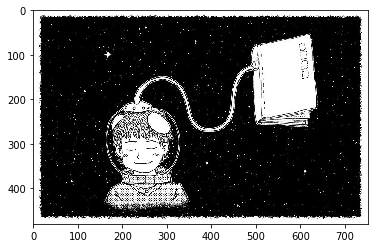

In [79]:
test_image1 = cv2.imread('dataset/testimages/[pixabay.com][29355].jpg')
test_image1 = cv2.cvtColor(test_image1,cv2.COLOR_BGR2RGB)
plt.imshow(test_image1)

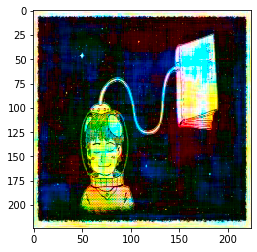

In [80]:
prediction = display(test_image1)
plt.imshow(prediction)

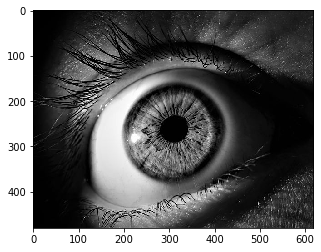

In [82]:
test_image2 = cv2.imread('dataset/testimages/[pixabay.com][160]eye-3221498480.jpg')
test_image2 = cv2.cvtColor(test_image2,cv2.COLOR_BGR2RGB)
plt.imshow(test_image2)

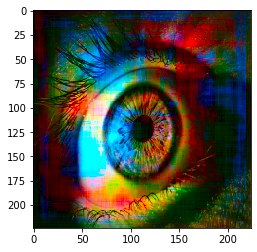

In [83]:
prediction = display(test_image2)
plt.imshow(prediction)

# Image Restoration with InPainting

In [14]:
def restore(image,image_marks):

    ret, thresh1 = cv2.threshold(image_marks, 254, 255, cv2.THRESH_BINARY)
    kernel = np.ones((7,7), np.uint8)
    mask = cv2.dilate(thresh1, kernel, iterations = 1)
    restored_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)
    return restored_image

In [18]:
image = cv2.imread('images/abraham.jpg')
image_mask = cv2.imread('images/mask.jpg', 0)
restored = restore(image,image_mask)

### Damaged Image

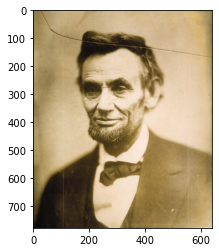

In [20]:
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Restored Image

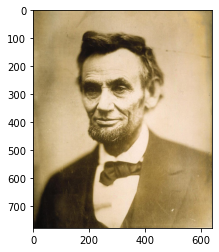

In [22]:
restored = cv2.cvtColor(restored,cv2.COLOR_BGR2RGB)
plt.imshow(restored)